In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from sklearn.cross_decomposition import PLSRegression

In [3]:
?PLSRegression

In [4]:
import csv
import matplotlib.pyplot as plt

In [5]:
from scipy import stats
from sklearn import linear_model
import random
from random import shuffle

In [6]:
import math
import numpy as np

In [7]:
df_ON_OF = pd.read_csv("ON_OF.txt", sep='\t')

In [8]:
df_YN_ON = pd.read_csv("YN_ON.txt", sep='\t')

In [9]:
df_YF_OF = pd.read_csv("YF_OF.txt", sep='\t')

In [10]:
df_YN_YF = pd.read_csv("YN_YF.txt", sep='\t')

In [11]:
df_ON = df_ON_OF[[19,4,6,7,8,9]];

In [12]:
df_OF = df_ON_OF[[19,4,10,11,12,13]]

In [13]:
df_YN = df_YN_ON[[19,4,6,7,8,9]]

In [14]:
df_YF = df_YN_YF[[19,4,10,11,12,13]]

In [15]:
def drop_dup(d):
    d = d.drop_duplicates(subset='gene', keep='first')
    return d

def merge(d1, d2):
    return pd.merge(d1, d2, how='outer', on=['gene','width'])

def merge2(d1, d2):
    return pd.merge(d1, d2, how='outer', on='gene')

In [16]:
dft = merge(df_ON, df_OF)

In [17]:
dft = merge(dft, df_YN)

In [18]:
dft = merge(dft, df_YF)

In [19]:
dft = drop_dup(dft)

In [20]:
dft.dropna(thresh=(2), axis=0);

In [21]:
dft = dft[pd.notnull(dft).all(axis=1)]

In [22]:
df = dft

In [23]:
state_dict = {'AT2.young.flu.20150416': 'YF', 'AT2.old.naive.20150416': 'ON', 
                 'AT2.old.flu.20150416': 'OF', 'AT2.young.naive.20150416': 'YN'}

In [24]:
def rename_cols(df, state_dict):
    cols = df.columns
    temp_cols = list(cols)
    #print temp_cols
    for c in range(len(cols)):
        state_name = cols[c][:-2]
        #sample_num = cols[c][-2:]
        total_name = cols[c]
        #print state_name
        if state_name in state_dict:
            new_state_name = state_dict[state_name]
            new_col = total_name.replace(state_name, new_state_name)
            temp_cols[c] = new_col
            #print abb_pair_dict[state_name]
    df.columns = temp_cols
    #print temp_cols
    return df
        
    

In [25]:
df = rename_cols(df, state_dict)

In [26]:
len(df)

14285

In [27]:
def df_to_names(df):
    
    name_dict = {}
        
    for i in range(2,len(df.columns)):
        name = df.columns[i][:-2]
        if name in name_dict:
            name_dict[name].append(i)
        else:
            name_dict[name] = [i]
            
    return name_dict

In [28]:
name_dict = df_to_names(df)

In [29]:
def coshuffle(X):
    
    new_X = [[] for i in range(len(X))]
    index_shuf = range(len(X[0]))
    shuffle(index_shuf)
    print index_shuf[:10]
    for i in range(len(X)):
        origX = X[i]
        for s in index_shuf:
            new_X[i].append(X[i][s])

    return new_X

In [30]:
gene_list = np.array(df['gene'])
gene_dict = {i: gene_list[i] for i in range(len(gene_list))}

In [31]:
xt = np.array(df.ix[:,range(2,18)])

In [32]:
def cycle_cols(X):
    Qs = []
    for i in range(500):#len(X)):
        y = np.array(df.ix[:,range(10,14)])[i]
        ir = [ii for ii in range(len(X)) if ii != i]
        Xt = np.array(df.ix[:,range(10,14)])[ir]
        X = Xt.transpose()
        Qs.append(calc_Q2(X, y, n_pcs = 2))
    return Qs

In [46]:
Qs = cycle_cols(xt)

NameError: global name 'calc_Q2' is not defined

In [36]:
plt.plot(list(Qs)[5:100])

NameError: name 'Qs' is not defined

In [37]:
print len([Q for Q in Qs if Q > 0.7])

NameError: name 'Qs' is not defined

In [38]:
#for i, Q in enumerate(Qs):
    #if Q > 0.5:
        #print i, Q;

In [39]:
df.columns

Index([u'gene', u'width', u'ON.1', u'ON.2', u'ON.3', u'ON.4', u'OF.1', u'OF.2',
       u'OF.3', u'OF.4', u'YN.1', u'YN.2', u'YN.3', u'YN.4', u'YF.1', u'YF.2',
       u'YF.3', u'YF.4'],
      dtype='object')

In [40]:
x_matrix = np.array(df.ix[:,range(11,18)]).transpose()

In [41]:
yflu = range(10,18)

In [42]:
oflu = range(2,10)

In [ ]:
aging = [2,3,4,5,10,11,12,13]

In [37]:
process = [yflu, oflu, aging]

In [33]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [34]:
def calc_acc(x_matrix, target_y, n_pcs):
    n_mice = len(x_matrix)
    pred = []
    
    pls = PLSRegression(n_pcs, scale=False)
    pls.fit(x_matrix, target_y)
    
    for mouse in range(n_mice):
        
        pred.append(pls.predict(x_matrix[mouse]))
        vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)
    
    error1 = 0
    error2 = 0
    l2 = int(len(target_y)/2)
    for p in range(len(pred)):
        if p < l2+1:
            error1 += abs(int(pred[p]) - target_y[p])
        else:
            error2 += abs(int(pred[p]) - target_y[p])
    
    return error1, error2

In [54]:
x_matrix[0]

array([  3.41610974,   0.09766976,   0.89417597, ...,  33.91488209,
         0.5041184 ,   0.39428383])

In [66]:
df.ix[:,[2,3,4,5,6,7,8,9]].transpose()

,0,1,3,4,5,6,7,8,9,10,...,14878,14879,14880,14881,14882,14883,14884,14886,14887,14888
ON.1,3.416110,0.097670,0.894176,10.409801,47.013339,0.268831,4.265999,0.983380,0.114189,0.032568,...,0.279462,0.806440,235.428104,1.005325,0.277532,0.133765,1.038193,33.914882,0.504118,0.394284
ON.2,3.009893,0.040609,0.757337,10.497557,41.137221,0.266620,3.509320,1.362911,0.215808,0.090275,...,0.258213,0.838261,315.876900,0.398093,0.109898,0.111234,0.261614,31.336109,0.531605,0.575217
ON.3,2.985305,0.069904,0.607386,11.710880,44.567283,0.266987,3.594959,1.700905,0.204317,0.058274,...,0.250020,1.442960,203.903122,0.642437,0.283764,0.239345,0.675503,35.398848,0.509836,0.436290
ON.4,3.308861,0.074135,0.843899,10.361103,45.876615,0.288828,3.849834,1.244032,0.090050,0.070629,...,0.255892,0.874451,260.714360,0.622919,0.085982,0.058018,0.716385,33.710486,0.404033,0.438786
OF.1,3.006839,0.073475,0.480479,9.809717,42.642833,0.323365,4.200088,1.479553,0.211965,0.105001,...,0.260289,0.650002,220.711672,0.617375,0.255651,0.143755,0.710010,33.410482,0.518213,0.133810
OF.2,3.288298,0.023836,0.444518,9.479280,48.403478,0.325023,4.276307,0.879955,0.177336,0.066233,...,0.267752,0.738025,230.226535,0.233660,0.258019,0.000000,1.151657,59.776281,0.374430,0.227895
OF.3,3.362613,0.033416,0.439068,9.501984,62.760002,0.320654,4.449298,1.205617,0.106550,0.097499,...,0.377146,1.034675,242.074774,0.737055,0.067824,0.228830,0.403642,21.756660,0.628044,0.186374
OF.4,3.246345,0.060919,0.533623,7.389288,57.323654,0.328175,4.606370,0.885967,0.097122,0.186207,...,0.284058,1.676664,346.278878,0.746487,0.247292,0.139055,0.490568,17.628048,0.569624,0.248083


In [35]:
target_y = np.array([0,0,0,0,1,1,1,1])
x_matrix = np.array(df.ix[:,[2,3,4,5,6,7,8,9]]).transpose()
pls = PLSRegression(3, scale=False)
pls.fit(x_matrix, target_y)
vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)

In [55]:
a = np.arange(0,27,3).reshape(3,3)

In [56]:
a

array([[ 0,  3,  6],
       [ 9, 12, 15],
       [18, 21, 24]])

In [57]:
row_sums = a.sum(axis=1)

In [58]:
row_sums

array([ 9, 36, 63])

In [62]:
new_mat = a / row_sums[:, np.newaxis]

In [64]:
new_mat[0][0]

0

In [37]:
vips

matrix([[ 0.00335589],
        [ 0.00060424],
        [ 0.00531307],
        ..., 
        [ 0.09216329],
        [ 0.00059035],
        [ 0.00585857]])

In [40]:
vs

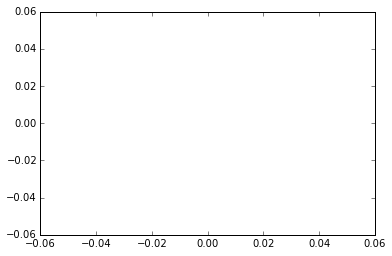

In [39]:
plt.plot(vs)

In [41]:
c = 0
for i in isets:
    target_y = np.array([0,0,0,0,1,1,1,1])
    x_matrix = np.array(df.ix[:,i]).transpose()
    err1, err2 = calc_acc(x_matrix, target_y, n_pcs=4)
    if c==0: name = "Young Illness"
    if c==1: name = "Old Illness"
    if c==2: name = "Aging"
    print 'Error for ', name, '=', err1, err2
    c += 1

NameError: name 'isets' is not defined

In [42]:
c = 0
for i in isets:
    target_y = np.array([0,0,0,0,1,1,1,1])
    x_matrix = np.array(df.ix[:,i]).transpose()
    Q2 = calc_Q2(x_matrix, target_y, n_pcs=4)
    Error = calc_err(x_matrix, target_y, n_pcs=4)
    if c==0: name = "Young Illness"
    if c==1: name = "Old Illness"
    if c==2: name = "Aging"
    print 'Q^2 for ', name, '=',Q2
    c += 1

NameError: name 'isets' is not defined

In [444]:
x_matrix = np.array(df.ix[:,aging]).transpose()

In [413]:
x_matrix = np.array(df.ix[:,range(2,10)]).transpose()

In [355]:
target_y = np.array([0,0,0,0,1,1,1,1])#,2,2,2,2])#,3,3,3,3])

In [262]:
n_pcs = 2
pls = PLSRegression(n_pcs, scale=False)
pls.fit(x_matrix, target_y)
vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)

In [43]:
n_pcs = 2
def get_vips(x_matrix, target_y, n_pcs):
    pls = PLSRegression(n_pcs, scale=False)
    pls.fit(x_matrix, target_y)
    vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)
    return vips

In [44]:
len(x_matrix)

8

In [45]:
vips = get_vips(x_matrix, target_y, n_pcs)

In [46]:
def list_vip_genes(vips):
    for i, v in enumerate(vips):
        if v > 10:
            print i, gene_dict[i], v[0]

In [47]:
list_vip_genes(vips)

2692 Sftpc [[ 66.95941976]]
3545 Scgb1a1 [[ 15.56251064]]
3756 Cbr2 [[ 11.71310801]]
4433 Lcn2 [[ 13.83918241]]
11641 H2-K1 [[ 10.73469854]]
11943 mt-Nd1 [[ 25.06349453]]
11946 mt-Nd2 [[ 30.31934349]]
11952 mt-Co1 [[ 49.6270573]]
11958 mt-Nd4 [[ 20.40794689]]
11959 mt-Nd5 [[ 22.57524502]]
11960 mt-Nd6 [[ 20.51030461]]
11961 mt-Te [[ 12.14029985]]
11962 mt-Cytb [[ 51.66142831]]
12692 Gm23935 [[ 14.10414617]]


In [48]:
vips = np.sort(vips, axis=0)[::-1]

In [49]:
vips

matrix([[  6.69594198e+01],
        [  5.16614283e+01],
        [  4.96270573e+01],
        ..., 
        [  2.34345524e-06],
        [  1.44697139e-06],
        [  4.46525831e-07]])

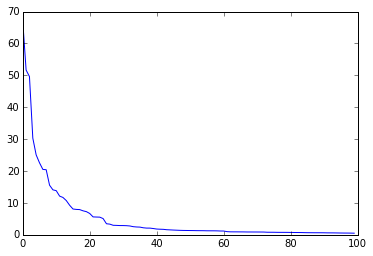

In [52]:
plt.plot(vips[:100])

In [315]:
def calc_Q2(x_matrix, target_y, n_pcs):
    n_mice = len(x_matrix)
    pred = []
    
    for mouse in range(n_mice):
        mice_ind = range(n_mice)
        loo_mouse = x_matrix[mouse]
        mice_ind.remove(mouse)
        x_matrix_t = x_matrix[(mice_ind)]
        target_y_t = target_y[(mice_ind)]
        pls = PLSRegression(n_pcs, scale=False)
        #print x_matrix
        #print target_y
        pls.fit(x_matrix_t, target_y_t)
        
        pred.append(pls.predict(loo_mouse))
        vips = vipp(x_matrix_t, target_y_t, pls.x_scores_, pls.x_weights_)
    
    num = 0
    den = 0
    for p in range(len(pred)):
        num += ((pred[p] - target_y[p])**2)
        den += ((target_y[p] - np.mean(target_y))**2)
    Q2 = float(1- num/den)
    
    return Q2

In [327]:
def calc_R2(x_matrix, target_y, n_pcs):
    n_mice = len(x_matrix)
    pred = []
    
    pls = PLSRegression(n_pcs, scale=False)
    pls.fit(x_matrix, target_y)
    
    for mouse in range(n_mice):
        
        pred.append(pls.predict(x_matrix[mouse]))
        vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)
    
    num = 0
    den = 0
    for p in range(len(pred)):
        num += ((pred[p] - target_y[p])**2)
        den += ((target_y[p] - np.mean(target_y))**2)
    R2 = float(1- num/den)
    
    return R2

In [464]:
round(0.6)

1.0

In [386]:
len(x_matrix)

8

In [445]:
Q2 = calc_Q2(x_matrix, target_y, n_pcs=2)

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a si

In [446]:
Q2

0.31957600882414383

In [389]:
R2 = calc_R2(x_matrix, target_y, n_pcs=2)

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a si

In [390]:
R2

0.9044349533854793

In [391]:
np.mean(target_y)

0.5

In [185]:
for mat in x_matrix:
    pls.predict(mat)

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a si

In [172]:
vipsa = np.array(vips)

In [ ]:
pls.predict

In [173]:
vipsa

array([[ 0.0172812 ],
       [ 0.00054983],
       [ 0.0057373 ],
       ..., 
       [ 0.50083962],
       [ 0.00670487],
       [ 0.0073769 ]])

In [174]:
gene_list[11923:11982]

array(['Rab3ip', '4430402I18Rik', 'Ano6', 'Ifi27', 'Chi3l1', 'Plcxd1',
       'Ethe1', 'Gimap8', 'Zfp428', 'Hvcn1', 'Ccdc146', 'Cdpf1', 'Tank',
       'Aox3', 'Clasp1', 'Lrrc51', 'Hhip', 'Siva1', 'mt-Rnr1', 'mt-Rnr2',
       'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Nd2', 'mt-Tw', 'mt-Ta', 'mt-Tn',
       'mt-Tc', 'mt-Ty', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6',
       'mt-Co3', 'mt-Nd3', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Te',
       'mt-Cytb', 'mt-Tt', 'mt-Tp', 'Sepp1', 'Rn7sk', 'Tacc1', 'Cpped1',
       'Aurkaip1', 'Dhrs3', 'Ubr4', 'Hnrnpr', 'Med18', 'Phactr4', 'Gm1976',
       'Muc5b', 'Adamtsl1', 'Kndc1', 'Prpf4', 'Cdc26', 'Slc31a1'], dtype=object)

2567 Sftpa1 [ 6.86361807]
2692 Sftpc [ 31.50918461]
2929 Ly6e [ 7.5887478]
3545 Scgb1a1 [ 39.15060487]
3550 Fth1 [ 6.02429228]
3756 Cbr2 [ 11.60840071]
3899 Ifitm3 [ 6.95634905]
4433 Lcn2 [ 11.44027598]
7988 Scd1 [ 15.76313038]
7993 Lrg1 [ 5.78466107]
11641 H2-K1 [ 9.18809931]
11927 Chi3l1 [ 7.13842117]
11943 mt-Nd1 [ 48.44249341]
11946 mt-Nd2 [ 20.82840118]
11952 mt-Co1 [ 31.95517667]
11954 mt-Atp8 [ 7.07148034]
11958 mt-Nd4 [ 21.46852349]
11959 mt-Nd5 [ 20.94123694]
11960 mt-Nd6 [ 17.9249754]
11961 mt-Te [ 23.72988147]
11962 mt-Cytb [ 59.85328262]
12167 Lyz1 [ 5.9551361]
12168 Lyz2 [ 14.96629672]
12434 H2-D1 [ 5.59088668]
12692 Gm23935 [ 21.93518974]
12700 Igkc [ 14.74442488]
12802 Ifi27l2a [ 5.61543903]
13828 Igha [ 7.74019115]
14255 Gm26924 [ 13.08865958]


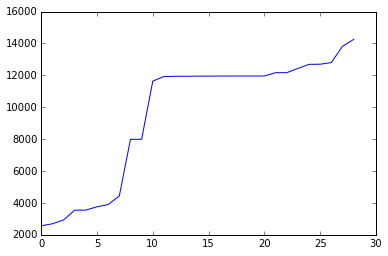

In [175]:
ti = []
for i in range(len(vipsa)):
    if vipsa[i] > 5:
        #print i
        print i, gene_dict[i], vipsa[i]
        ti.append(i)
plt.plot(ti)

In [67]:
vipdf = pd.DataFrame(np.sort(vips, axis=0))

In [69]:
vipsort = vipdf.columns[::-1]

In [70]:
vipsort

Int64Index([0], dtype='int64')

In [28]:
def unique(a, b):
    return list([a[i] for i in range(1,len(a)) if a[i] not in b])
def intersect(a, b):
    return list(set(a) & set(b))
def union(a, b):
    return list(set(a) | set(b))
def intersect3(a, b, c):
    return list(set(a) & set(b) & set(c))

def unique3(a, b, c, index):
    uniques = [0 for i in range(3)]
    uniques[0] = list([a[i] for i in range(1,len(a)) if a[i] not in b and a[i] not in c])
    uniques[1] = list([b[i] for i in range(1,len(b)) if b[i] not in a and b[i] not in c])
    uniques[2] = list([c[i] for i in range(1,len(c)) if c[i] not in a and c[i] not in b])
    return uniques[index]
